In [4]:
import os
import tensorflow as tf
import glob as glob
import matplotlib.pyplot as plt
import random
import numpy as np
from dataclasses import dataclass
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = (12, 9)
block_plot = False

# Fix seeds for reproducibility.
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [5]:
# Download and Extract dataset
import requests

def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

download_file('https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1', 'dataset_balls.zip')

In [6]:
import zipfile

zip_file = 'dataset_balls.zip'
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall("./")
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


In [7]:
# Class names.
class_names = sorted([f for f in os.listdir('./dataset_balls/train') if not f.startswith('.')])

for i in range(len(class_names)):
    print(i, class_names[i])

0 baseball
1 basketball
2 beachballs
3 billiard ball
4 bowling ball
5 brass
6 buckeyballs
7 cannon ball
8 cricket ball
9 eyeballs


In [8]:
# Data Visualization
def get_all_image_paths(dir_path):

    # Retrieve all the images paths.
    image_paths = glob.glob(f"{dir_path}/train/*/*", recursive=True)
    return image_paths

In [9]:
def display_dataset_samples(image_paths):

    plt.figure(figsize=(18, 12))
    num_rows = 5
    num_cols = 8
    for i in range(num_rows*num_cols):
        plt.subplot(num_rows, num_cols, i+1)

        # Generate a random index.
        random_idx = random.choice(list(range(0, len(image_paths))))
        image = plt.imread(image_paths[random_idx])
        label = image_paths[random_idx].split('/')[-2]
        plt.imshow(image)
        plt.axis('off')
        plt.title(label)

    plt.show(block=block_plot)

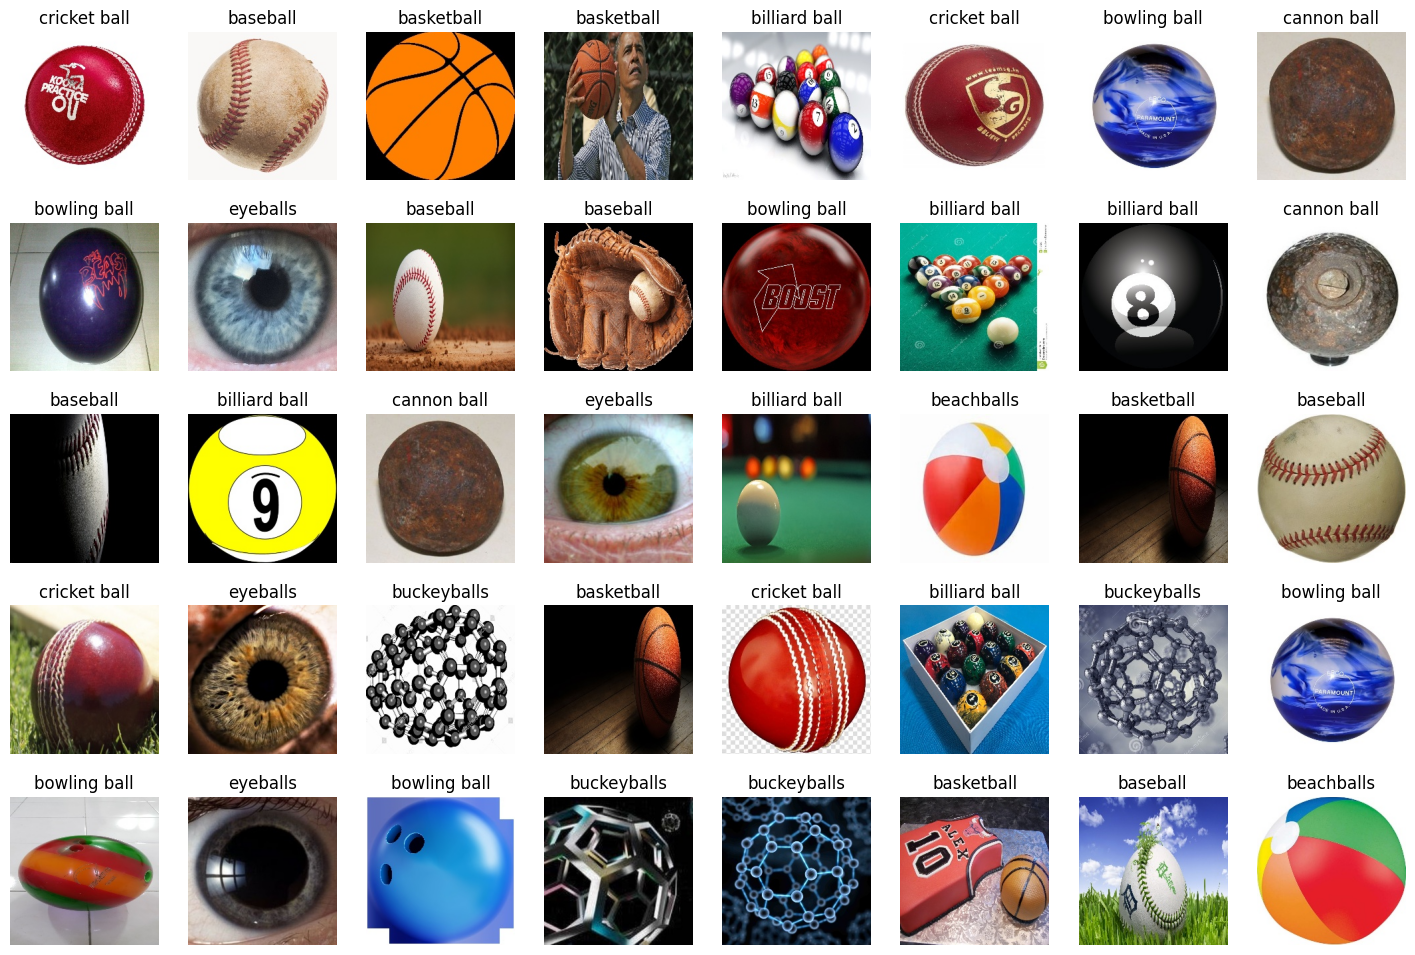

In [10]:
# Get all the image paths.
image_paths = get_all_image_paths('./dataset_balls')

# Display several random images from the dataset.
display_dataset_samples(image_paths)

In [11]:
# Set Data Configuration Parameters
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 224
    IMG_WIDTH:    int = 224
    NUM_CHANNELS: int = 3
    BATCH_SIZE:   int = 64
    DATA_ROOT:    str = './dataset_balls'

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 21
    LEARNING_RATE:  float = 0.001
    CHECKPOINT_DIR: str   = './saved_models_balls.keras'

data_config = DatasetConfig()
training_config = TrainingConfig()

# Set data paths.
train_path = os.path.join(data_config.DATA_ROOT, "train")
valid_path = os.path.join(data_config.DATA_ROOT, "valid")

In [12]:
# Create Batch Dataset
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH)
batch_size = data_config.BATCH_SIZE

train_dataset = image_dataset_from_directory(directory=train_path,
                                             image_size=input_shape,
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

valid_dataset = image_dataset_from_directory(directory=valid_path,
                                             image_size=input_shape,
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

Found 1125 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


In [13]:
# Inspect Dataset Object
# Print the shape of the data and the aassociated labels.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

# Or use the take() method as shown below to retrieve the first batch only.
# print('\n')
# for data_batch, labels_batch in train_dataset.take(1):
#     print("data batch shape:", data_batch.shape)
#     print("labels batch shape:", labels_batch.shape)

data batch shape: (64, 224, 224, 3)
labels batch shape: (64, 10)


In [14]:
# The following command will print the various attrubites for the BatchDataset object.
[m for m in dir(valid_dataset) if not m.startswith('_')]

['apply',
 'as_numpy_iterator',
 'batch',
 'bucket_by_sequence_length',
 'cache',
 'cardinality',
 'choose_from_datasets',
 'class_names',
 'concatenate',
 'counter',
 'element_spec',
 'enumerate',
 'file_paths',
 'filter',
 'fingerprint',
 'flat_map',
 'from_generator',
 'from_tensor_slices',
 'from_tensors',
 'get_single_element',
 'group_by_window',
 'ignore_errors',
 'interleave',
 'list_files',
 'load',
 'map',
 'options',
 'padded_batch',
 'prefetch',
 'ragged_batch',
 'random',
 'range',
 'rebatch',
 'reduce',
 'rejection_resample',
 'repeat',
 'sample_from_datasets',
 'save',
 'scan',
 'shard',
 'shuffle',
 'skip',
 'snapshot',
 'sparse_batch',
 'take',
 'take_while',
 'unbatch',
 'unique',
 'window',
 'with_options',
 'zip']

In [15]:
# You can use the object attribute (class_names) to access the class names in the dataset.
valid_dataset.class_names

['baseball',
 'basketball',
 'beachballs',
 'billiard ball',
 'bowling ball',
 'brass',
 'buckeyballs',
 'cannon ball',
 'cricket ball',
 'eyeballs']

In [16]:
# You can use the object attribute (file_paths) to access the path names in the dataset.
# valid_dataset.file_paths

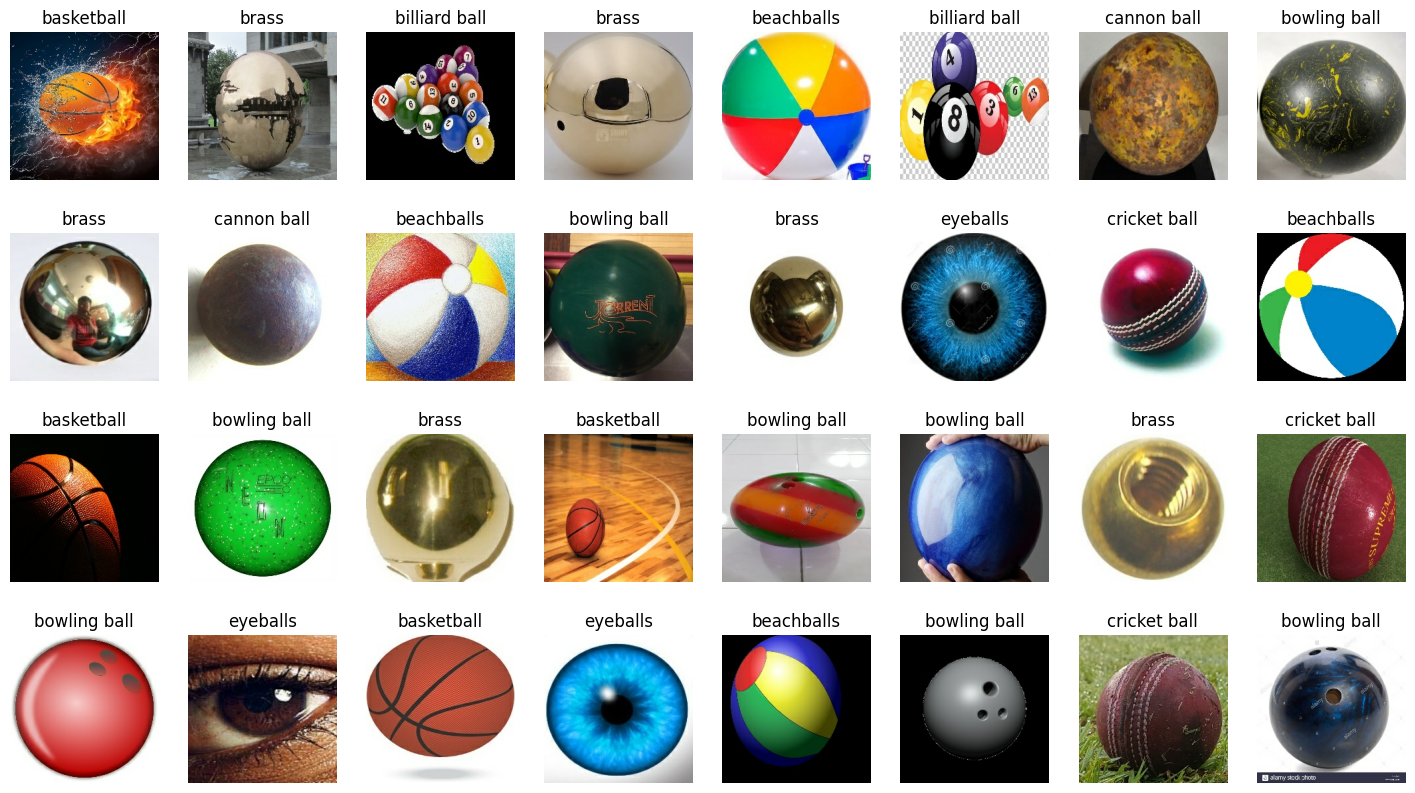

In [17]:
# Use batch dataset object to access image data
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for data_batch, labels_batch in train_dataset.take(1):

    # For the batch of images and the associated (one-hot encoded) labels,
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(data_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

# To loop through all batches in the dataset, use:
# for data_batch, labels_batch in train_dataset:

In [18]:
# Train a Deep NN Model
# Define the model.
def cnn_model(input_shape=(224, 224, 3), num_classes=10):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [19]:
# Define the input shape.
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH, data_config.NUM_CHANNELS)

# Create the model.
model = cnn_model(input_shape=input_shape, num_classes=data_config.NUM_CLASSES)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,868,010 (102.49 MB)

 Trainable params: 26,868,010 (102.49 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Create a model checkpoint callback to save the "best" model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=training_config.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor="val_accuracy",
                                                               mode="max",
                                                               save_best_only=True,
                                                              )

# Train the model.
training_results = model.fit(train_dataset,
                             epochs=training_config.EPOCHS,
                             validation_data=valid_dataset,
                             callbacks=model_checkpoint_callback,
                            )

Epoch 1/21
16/18 ━━━━━━━━━━━━━━━━━━━━ 48s 24s/step - accuracy: 0.1166 - loss: 2.6758 

In [ ]:
# Plot Training Results
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_dataset)
print(f"Validation accuracy: {valid_acc:.3f}")

In [ ]:
def evaluate_model(dataset, checkpoint_dir=None):

    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(),training_config.CHECKPOINT_DIR)

    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):

        predictions = model.predict(data_batch)

        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())

            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})

            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')

            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)

    return

In [ ]:
evaluate_model(valid_dataset, training_config.CHECKPOINT_DIR)